# CS 315 - Jaccard Index Analysis

Author: Audrey Yip (with help from Eni Mustafaraj)

Date: Feb 14 2024

**Table of Contents**
1. [Importing Data](#sec1)
2. [Exploratory Analysis](#sec2)
3. [Jaccard Analysis](#sec3)
4. [Visualizations](#sec4)

In [2]:
import os, csv
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

/var/folders/94/hzlwrw5d571cgm5snsf618b00000gn/T/ipykernel_67936/3262664426.py:3: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


<a id="sec1"></a>
### 1. Importing Data

In [3]:
files = os.listdir('data') # function lists the content of a directory
files

['02-14-16-57_save_data_all_videos_AY.csv',
 '02-14-16-57_data_saved_videos_AY.csv',
 '02-14-19-04_save_data_all_videos_AY.csv',
 '02-14-16-57_control_data_all_videos_AY.csv',
 '02-14-20-33_save_data_all_videos.csv',
 '02-14-17-04_data_saved_videos.csv',
 '02-14-17-05_control_data_all_videos.csv',
 '02-14-20-33_data_saved_videos.csv',
 '02-14-19-03_control_data_all_videos_AY.csv',
 '02-14-20-34_control_data_all_videos.csv',
 '02-14-19-04_data_saved_videos_AY.csv',
 '02-14-17-04_save_data_all_videos.csv']

In [4]:
# create tuples for each pair during data collection
onlyAllData = [f for f in files if 'data_all' in f]     # filter out saved videos
onlyAllData = sorted(onlyAllData)

collection_times = []

for i in range(0, len(onlyAllData) - 1, 2):
    collection_times.append((onlyAllData[i][:11], onlyAllData[i+1][:11]))

print(collection_times)

[('02-14-16-57', '02-14-16-57'), ('02-14-17-04', '02-14-17-05'), ('02-14-19-03', '02-14-19-04'), ('02-14-20-33', '02-14-20-34')]


In [5]:
## Helper functions
def createPostID(row):
    """helper function: create a new value using music and author"""
    return f"{row['music']}_{row['author']}"

# for splitting hashtags  
splitter = lambda x: np.nan if pd.isna(x) else [s.strip() for s in str(x).split(',')]

In [6]:
# create 3 dfs: control data, save data, all data

control_dfs = []
save_dfs = []
all_dfs = []

for fN in onlyAllData: # folder with files that have all posts
    path = os.path.join('data', fN) # create file path
    df = pd.read_csv(path) # create dataframe

    # add column to indicate date/time collected
    df['collectionTime'] = fN[:11]

    # add column with unique post id
    df['postID'] = df.apply(createPostID, axis=1) # use axis=1 to process one row at a time

    # split hashtags into list
    #df['hashtag'] = df['hashtag'].apply(splitter)

    if 'control'in fN:
        control_dfs.append(df)
    else:
        save_dfs.append(df)

    all_dfs.append(df)


df_control = pd.concat(control_dfs, ignore_index=True)
df_save = pd.concat(save_dfs, ignore_index=True)
df_all = pd.concat(all_dfs, ignore_index=True)

print("control shape:", df_control.shape)
print("save shape:", df_save.shape)
print("all data shape:", df_all.shape)


control shape: (1912, 11)
save shape: (1954, 11)
all data shape: (3866, 11)


In [7]:
df_control.head()

,batch,index,music,hashtag,author,likes,comments,shares,saves,collectionTime,postID
0,1,0,original sound - ®️ Louieveegang💙,@louieveemoonteenmoonfam,louieveedee,297300,1571,20300,721,02-14-16-57,original sound - ®️ Louieveegang💙_louieveedee
1,1,1,original sound - dayz915,"atodamadre%F0%9F%8F%A7, %F0%9F%A4%99%F0%9F%8F%...",dayz.915,522299,3713,36500,142900,02-14-16-57,original sound - dayz915_dayz.915
2,1,2,original sound - DermDoctor | Dr. Shah,"@poblanopepp, dermatographia",dermdoctor,430100,4758,24900,6591,02-14-16-57,original sound - DermDoctor | Dr. Shah_dermdoctor
3,1,3,original sound - 𝐝𝐢𝐧𝐨 🎀,"@lashedchars, fy, fyp, fyp%E3%82%B7%E3%82%9Avi...",marschvarl,251,29,31,0,02-14-16-57,original sound - 𝐝𝐢𝐧𝐨 🎀_marschvarl
4,1,4,original sound - AfroSamuraiT,"lifehack, lifehacks, challenge, ksi, prime",afrosamuraitt,65200,3487,11700,189,02-14-16-57,original sound - AfroSamuraiT_afrosamuraitt


<a id="sec2"></a>
### 2. Exploratory Analysis

In [8]:
# check for null values
df_all[['music','author', 'hashtag']].isna().sum() 

music        0
author       0
hashtag    969
dtype: int64

<a id="sec3"></a>
### 3. Jaccard Analysis 

In [9]:
## define function for calculating jaccard index

def jaccard_index(list_1, list_2):
    set_1 = set(list_1)
    set_2 = set(list_2)
    intersection = len(set_1.intersection(set_2))
    union = len(set_1.union(set_2))
    return intersection / union if union != 0 else 0

In [10]:
# create new df with difference of feeds for each collectionTime
jaccard_list = []
variables = ['hashtag', 'author', 'music']

for coll_time in collection_times:
    jaccard_dict = {}
    for variable in variables:
        sub_df_control = df_control[df_control['collectionTime'] == coll_time[0]]
        sub_df_saves = df_save[df_save['collectionTime'] == coll_time[1]]

        control_list = sub_df_control[variable].dropna().tolist()
        save_list = sub_df_saves[variable].dropna().tolist()

        if variable == 'hashtag':
            control_list = [x for x in control_list if x != 'fyp']
            save_list = [x for x in save_list if x != 'fyp']

        diff_val = 1 - jaccard_index(control_list, save_list)
        jaccard_dict[variable] = diff_val
    
    jaccard_list.append(jaccard_dict)

df_diff = pd.DataFrame(jaccard_list, index=[tup[0] for tup in collection_times])
df_diff

,hashtag,author,music
02-14-16-57,0.916042,0.897983,0.894289
02-14-17-04,1.000000,1.000000,1.000000
02-14-19-03,0.984772,0.988304,0.984344
02-14-20-33,1.000000,1.000000,1.000000


<a id="sec4"></a>
### 4. Visualizations

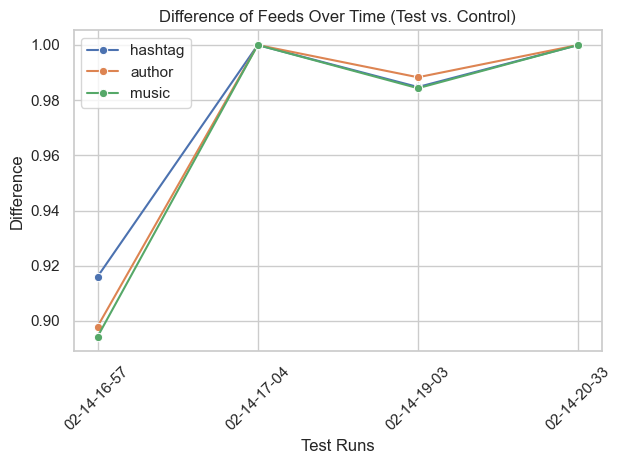

In [22]:
collection_times = df_diff.index.tolist()

sns.set(style="whitegrid")  # Set the style
#plt.figure(figsize=(10, 6))  # Set the figure size
sns.lineplot(data=df_diff, marker='o', dashes=False)  # Create line plot



plt.title('Difference of Feeds Over Time (Test vs. Control)')  # Set title
plt.xlabel('Test Runs')  # Set x-axis label
plt.ylabel('Difference')  # Set y-axis label
plt.xticks(ticks=range(len(collection_times)), labels=collection_times, rotation=45)  # Rotate x-axis labels for better readability
plt.tight_layout()  # Adjust layout
plt.show()  # Show plot

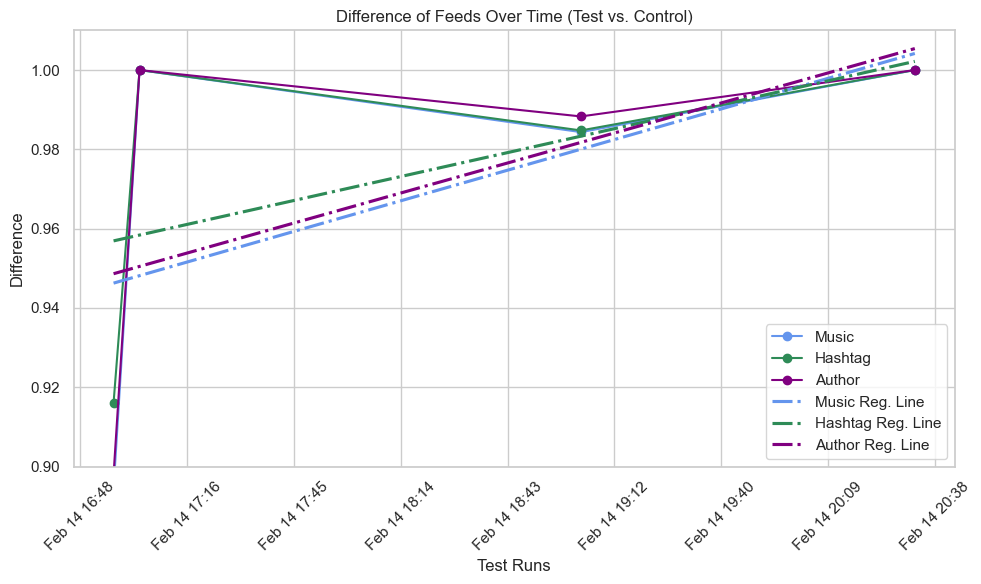

In [78]:
import matplotlib
from datetime import datetime
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns


# Make times numeric
collection_times = df_diff.index
collection_times = [datetime.strptime(dt_str, "%m-%d-%H-%M") for dt_str in collection_times]
numeric_times = mdates.date2num(collection_times)

sns.set(style="whitegrid")  # Set the style

plt.figure(figsize=(10, 6))  # Set the figure size

# Create line plot for each category and specity color
plt.plot(numeric_times, df_diff['music'], marker='o', linestyle='-', color='cornflowerblue', label='Music')
plt.plot(numeric_times, df_diff['hashtag'], marker='o', linestyle='-', color='seagreen', label='Hashtag')
plt.plot(numeric_times, df_diff['author'], marker='o', linestyle='-', color='purple', label='Author')

# Create regression lines 
sns.regplot(x=numeric_times, y=df_diff['music'], scatter=False, color='cornflowerblue', label='Music Reg. Line', ci=None, line_kws={'linestyle':'-.'})
sns.regplot(x=numeric_times, y=df_diff['hashtag'], scatter=False, color='seagreen', label='Hashtag Reg. Line', ci=None, line_kws={'linestyle':'-.'})
sns.regplot(x=numeric_times, y=df_diff['author'], scatter=False, color='purple', label='Author Reg. Line', ci=None, line_kws={'linestyle':'-.'})

# Format numeric times to look like dates
date_format = mdates.DateFormatter('%b %d %H:%M')  
plt.gca().xaxis.set_major_formatter(date_format)

plt.title('Difference of Feeds Over Time (Test vs. Control)')  # Set title
plt.xlabel('Test Runs')  # Set x-axis label
plt.ylabel('Difference')  # Set y-axis label
plt.ylim(0.9, 1.01)
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.legend()  # Show legend
plt.tight_layout()  # Adjust layout
plt.show()  # Show plot
